In [1]:
from numpy import loadtxt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, confusion_matrix, log_loss, make_scorer
import numpy as np
import pandas as pd
import multiprocessing
import concurrent.futures
import uproot
import collections
import matplotlib.pyplot as plt

In [2]:
Tree = uproot.open("/home/ambroz/VHbb/CxAOD_ImplementationXGBoost/CxAODFramework_branch_master_21.2.59_1/run/mva_ntuples.root")["Nominal"]

In [3]:
Tree.show()

sample                     TStreamerInfo              asgenobj(STLString())
EventWeight                (no streamer)              asdtype('>f4')
bTagWeight                 (no streamer)              asdtype('>f4')
EventNumber                (no streamer)              asdtype('>u8')
ChannelNumber              (no streamer)              asdtype('>i4')
nJ                         (no streamer)              asdtype('>i4')
nSigJet                    (no streamer)              asdtype('>i4')
nForwardJet                (no streamer)              asdtype('>i4')
nTags                      (no streamer)              asdtype('>i4')
nTaus                      (no streamer)              asdtype('>i4')
MET                        (no streamer)              asdtype('>f4')
MEff                       (no streamer)              asdtype('>f4')
METSig                     (no streamer)              asdtype('>f4')
dPhiVBB                    (no streamer)              asdtype('>f4')
dEtaVBB                    

In [4]:
DataFrame = Tree.pandas.df(["nJ", 
                            "BDT","ProbSignal",
                            "MET",
                            "EventWeight", "EventNumber", "nTags",
                            "sample"])

Remove data, VHcc from samples and events with more than 3 jets:

In [5]:
DataFrame = DataFrame[ (DataFrame["sample"] != b'data')
                   &   (DataFrame["sample"] != b'qqZvvH125cc') 
                   &   (DataFrame["sample"] != b'qqWlvH125cc')
                   &   (DataFrame["sample"] != b'qqZllH125cc')
                   &   (DataFrame["sample"] != b'ggZvvH125cc')
                   &   (DataFrame["sample"] != b'ggZllH125cc')
                   &   (DataFrame["nTags"]  == 2)
                   &   (DataFrame["nJ"] < 4) ]

Samples availables:

In [6]:
factor = pd.factorize(DataFrame['sample'])

In [7]:
factor[1]

Index([      b'Wbb',       b'Wbl',       b'Wbc',       b'Wcc',       b'Wcl',
              b'Wl',        b'WZ',        b'ZZ',       b'Zbb',       b'Zbl',
             b'Zbc',       b'Zcl',       b'Zcc',        b'Zl', b'ggZllH125',
            b'ggZZ', b'ggZvvH125', b'qqWlvH125', b'qqZllH125', b'qqZvvH125',
          b'stopWt',     b'stops',     b'stopt',     b'ttbar',        b'WW',
            b'ggWW'],
      dtype='object')

Number of entries:

In [8]:
len(factor[0])

17583108

Now let's load Cython to speed up the computation of the class:

In [9]:
%load_ext Cython

In [10]:
%%cython 
def assign_class(object sample):
    
    #Class 1: signal
    if sample == b'qqZvvH125':
        return 1
    if sample == b'ggZvvH125':
        return 1
    if sample == b'qqZllH125':
        return 1
    if sample == b'ggZllH125':
        return 1
    if sample == b'qqWlvH125':
        return 1
    
    
    return 0

Classify the samples according to the classes:

In [11]:
DataFrame['Class'] = DataFrame.apply(lambda row: assign_class(row["sample"]), axis=1)

In [12]:
DataFrame[DataFrame["Class"] == 1].head()

nJ       BDT  ProbSignal         MET  EventWeight  EventNumber  \
14434356   2  0.263106    0.884147  153.066940     0.000352         8710   
14434368   3  0.428754    0.846494  155.740463     0.000304        63097   
14434370   3  0.605768    0.908206  193.739777     0.000301        62989   
14434375   2  0.397986    0.823711  154.835327     0.000290        62975   
14434379   2  0.248173    0.904432  182.739487     0.000327        67999   

          nTags        sample  Class  
14434356      2  b'ggZllH125'      1  
14434368      2  b'ggZllH125'      1  
14434370      2  b'ggZllH125'      1  
14434375      2  b'ggZllH125'      1  
14434379      2  b'ggZllH125'      1

In [13]:
DataFrame2jet = DataFrame[DataFrame["nJ"] == 2]
DataFrame3jet = DataFrame[DataFrame["nJ"] == 3]

In [14]:
DataFrame2jet_150_250 = DataFrame2jet[DataFrame2jet["MET"] < 250]
DataFrame3jet_150_250 = DataFrame3jet[DataFrame3jet["MET"] < 250]

In [15]:
DataFrame2jet_250 = DataFrame2jet[DataFrame2jet["MET"] > 250]
DataFrame3jet_250 = DataFrame3jet[DataFrame3jet["MET"] > 250]

In [16]:
DataFrames = {
    '2jet_150_250' : DataFrame2jet_150_250,
    '2jet_250'     : DataFrame2jet_250,
    '3jet_150_250' : DataFrame3jet_150_250,
    '3jet__250'    : DataFrame3jet_250,
}

In [17]:
list(DataFrames.keys())

['2jet_150_250', '2jet_250', '3jet_150_250', '3jet__250']

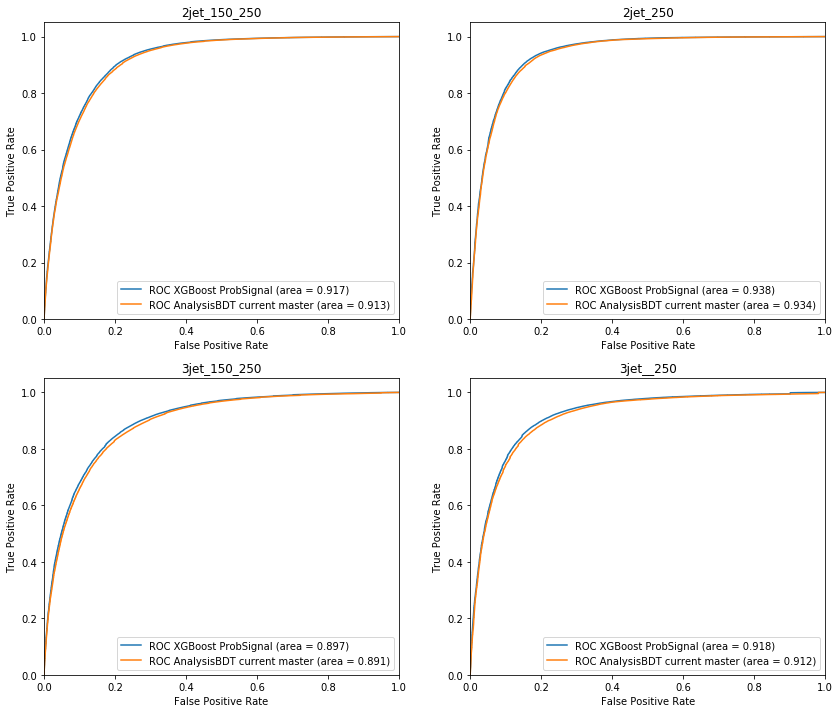

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12)) 
axes = axes.ravel()

for i, region in enumerate(list(DataFrames.keys())):
    fpr_XGBoost, tpr_XGBoost, _ = roc_curve(DataFrames[region]['Class'], DataFrames[region]['ProbSignal'],  sample_weight = abs(DataFrames[region]['EventWeight']))
    roc_auc_XGBoost = auc(fpr_XGBoost, tpr_XGBoost)
    fpr_AnalysisBDT, tpr_AnalysisBDT, _ = roc_curve(DataFrames[region]['Class'], DataFrames[region]['BDT'],  sample_weight = abs(DataFrames[region]['EventWeight']))
    roc_auc_AnalysisBDT = auc(fpr_AnalysisBDT, tpr_AnalysisBDT)
    
    plt.sca(axes[i])
    plt.plot(fpr_XGBoost, tpr_XGBoost, label = 'ROC XGBoost ProbSignal (area = %0.3f)' % roc_auc_XGBoost)
    plt.plot(fpr_AnalysisBDT, tpr_AnalysisBDT, label = 'ROC AnalysisBDT current master (area = %0.3f)' % roc_auc_AnalysisBDT)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(region)
    plt.legend(loc="lower right")

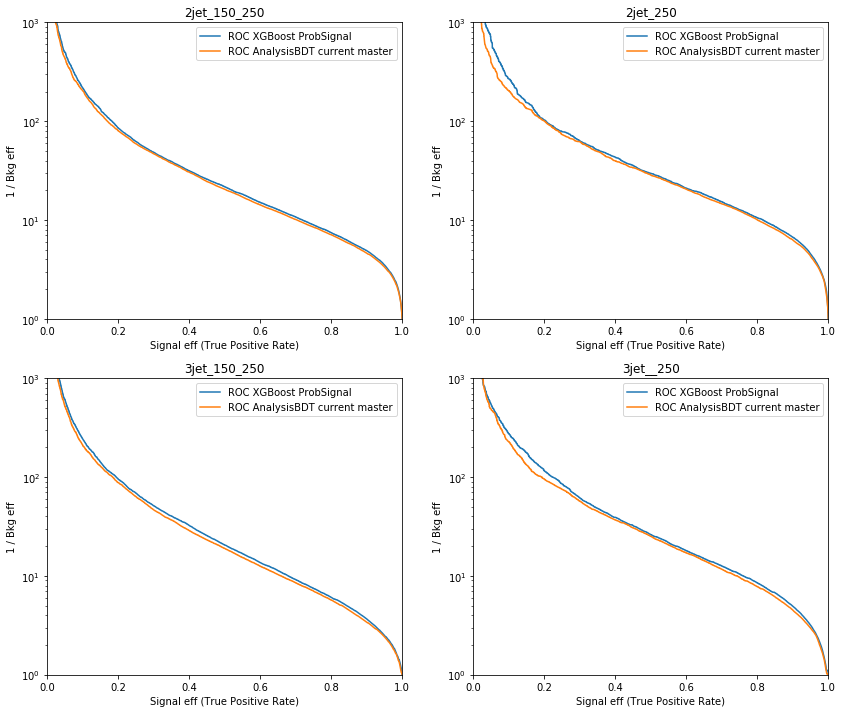

In [24]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12)) 
axes = axes.ravel()

for i, region in enumerate(list(DataFrames.keys())):
    fpr_XGBoost, tpr_XGBoost, _ = roc_curve(DataFrames[region]['Class'], DataFrames[region]['ProbSignal'],  sample_weight = abs(DataFrames[region]['EventWeight']))
    roc_auc_XGBoost = auc(fpr_XGBoost, tpr_XGBoost)
    fpr_AnalysisBDT, tpr_AnalysisBDT, _ = roc_curve(DataFrames[region]['Class'], DataFrames[region]['BDT'],  sample_weight = abs(DataFrames[region]['EventWeight']))
    roc_auc_AnalysisBDT = auc(fpr_AnalysisBDT, tpr_AnalysisBDT)
    
    plt.sca(axes[i])
    plt.plot(tpr_XGBoost, 1/(fpr_XGBoost+0.00001), label = 'ROC XGBoost ProbSignal')
    plt.plot(tpr_AnalysisBDT, 1/(fpr_AnalysisBDT+0.00001), label = 'ROC AnalysisBDT current master')
    plt.xlim([0.0, 1.0])
    plt.ylim([1, 1e3])
    plt.yscale('log')
    plt.xlabel('Signal eff (True Positive Rate)')
    plt.ylabel('1 / Bkg eff')
    plt.title(region)
    plt.legend(loc="upper right")